PREDICTING THE S&P500

In my exploratory data analysis I fit several models based on weekly S&P 500 Data, I found that all of my models struggled to achieve any actual predictive power. My theory is that weekly data is effective for the normal week to week movements of the index, but I believe it struggles to capture the whole picture of the big movements. In 1 week the market can drastically change and a model only containing weekly data would really struggle to understand these movements. This inspired me to compile a dataset of daily data from the S&P 500 over the last 10 years that will hopefully allow me to capture the full picture of the data. My goal is to build a series of models and find one with ACTUAL predictive power, that can aid small companies in making and maintaing conviction in their financial decisions

In [371]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, OrdinalEncoder, StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.pipeline import Pipeline
from statsmodels.tsa.stattools import adfuller
from sklearn import set_config
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
import tensorflow as tf
from tensorflow import keras
import statsmodels.api as sm
from statsmodels.tsa.filters.filtertools import convolution_filter
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.graphics.tsaplots as tsplots
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.graphics.tsaplots as tsaplots
import warnings
warnings.filterwarnings("ignore")

In [372]:
data = pd.read_csv('data/SP500dailydata.csv')

In [373]:
data.info()
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index(data['Date'])
data= data.drop('Date',axis=1)
data= data.dropna()
data.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2502 entries, 0 to 2501
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   2501 non-null   object 
 1   sp_500_prev_day_close  2501 non-null   float64
 2   vix_prev_day           2501 non-null   float64
 3   nasdaq_prev_day        2501 non-null   float64
 4   russell_2000_prev_day  2501 non-null   float64
 5   prev_volume            2502 non-null   int64  
 6   close_price            2501 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 137.0+ KB


,sp_500_prev_day_close,vix_prev_day,nasdaq_prev_day,russell_2000_prev_day,prev_volume,close_price
Date,,,,,,
2025-01-03,5868.55,17.93,19280.79,23.72,50203980,5942.47
2023-05-18,4158.77,16.87,12500.57,22.54,87286961,4198.05
2016-04-01,2059.74,13.95,4869.85,18.28,94584109,2072.78
2017-01-06,2269.00,11.67,5487.94,18.26,78379008,2276.98
2021-03-16,3968.94,20.03,13459.71,30.24,73592305,3962.71
2016-11-23,2202.94,12.41,5386.35,17.97,67428961,2204.72
2021-03-23,3940.59,18.88,13377.54,28.18,73778648,3910.52
2020-02-11,3352.09,15.04,9628.39,16.97,42070008,3357.75
2020-05-01,2912.43,34.15,8889.55,42.62,122901695,2830.71


Below I created a column for log returns, log returns are stationary- making then more easily digestible for time series models.

In [374]:
data['log_returns'] = np.log(data['close_price']).diff().dropna()
data['points_change'] = data['close_price'].diff().dropna()
data= data.dropna()

In [375]:
data['prev_volume']=data['prev_volume'].astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2500 entries, 2015-09-01 to 2025-08-11
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sp_500_prev_day_close  2500 non-null   float64
 1   vix_prev_day           2500 non-null   float64
 2   nasdaq_prev_day        2500 non-null   float64
 3   russell_2000_prev_day  2500 non-null   float64
 4   prev_volume            2500 non-null   int64  
 5   close_price            2500 non-null   float64
 6   log_returns            2500 non-null   float64
 7   points_change          2500 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 175.8 KB


Below I will take the average of the absolute value of the daily change in points and also the standard deviation of Log Returns which will give us metrics to compare our models to:

Text(0, 0.5, 'Weekly Closing Price ($)')

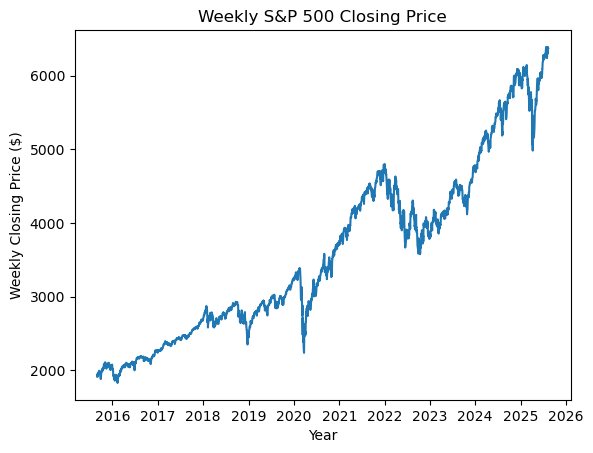

In [376]:
#This plot shows the weekly closing price of the S&P500 since 1982
plt.plot(data['close_price'])
plt.title('Weekly S&P 500 Closing Price')
plt.xlabel('Year')
plt.ylabel('Weekly Closing Price ($)')

Text(0, 0.5, 'Change in Price')

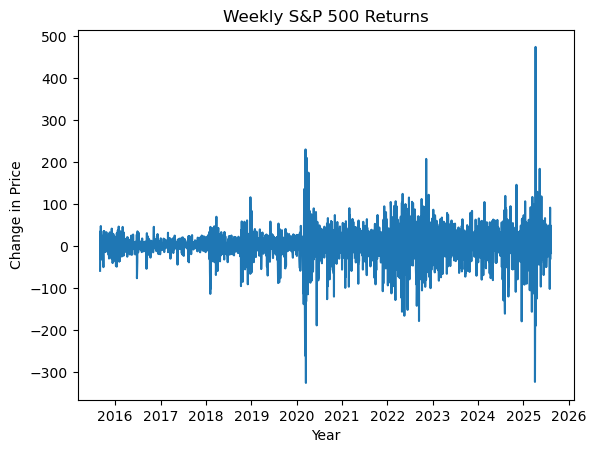

In [377]:
#This plot shows the weekly returns of the S&P500 in %
plt.plot(data['points_change'])
plt.title('Weekly S&P 500 Returns')
plt.xlabel('Year')
plt.ylabel('Change in Price')

Now i'll start preparing the data for modeling: Rather than predicting the actual price of the S&P500, or its simple returns, i have opted to predict log returns. Log returns I believe will be easier for both the model and myself to interpret. Log Returns should be closer to a normal distrubution, which should make it easier to interpret for the models. Also they are easy to transform, after the fact, to dollar amounts.

In [378]:
X=data.drop(['close_price','log_returns','points_change'],axis=1)
y=data['log_returns']

Now I will make an initial Linear Regression. Linear Regressions aren't typically used to model time series data, so I am using this as somewhat of a baseline to see how it will perform. I don't expect this model to be accurate at all, but it will give us an idea of how nuanced financial data is and how crucial the sequential aspect is of it.

In [379]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=42,shuffle=False)

Below I have transformed the data to make it stationary. This data will be more suitable to the time series models which perform best with stationary data.

In [380]:
X1_train = X_train.diff().dropna()
X1_test = X_test.diff().dropna()
y1_train = y_train.loc['2015-9-2':]
y1_test = y_test.loc['2023-8-15':]

In [381]:
numerical=['sp_500_prev_day_close','vix_prev_day','nasdaq_prev_day','russell_2000_prev_day','prev_volume']

In [382]:
# This is the transformer for my regression model, it will transform and scale the data to hopefully fit the data better.
polytransformer = Pipeline([        
                                    ('poly',PolynomialFeatures(degree = 3,include_bias=False)),
                                    ('scale',StandardScaler())
                                ])
transformer = [('polynomialtransformations',polytransformer,numerical)]
transform = ColumnTransformer(transformers = transformer,remainder='passthrough')

I have decided to forgo removing/filling any outliers, my thought is that because of the nature of financial data, outliers are important datapoints for the model to understand in this circumstance. For example, although the rapid changes during COVID are definitely outliers, rapid changes like this do happen in financial markets, so I believe the models should be aware of what they look like.

In [383]:
initialpipe = Pipeline([
    ('transform',transform),
    ('reg',LinearRegression())
])


In [384]:
linreg = initialpipe.fit(X1_train,y1_train)

In [385]:
linreg_train_preds = linreg.predict(X1_train)
linreg_test_preds = linreg.predict(X1_test)
linregtrainerror = mean_squared_error(linreg_train_preds,y1_train)
linregerror = mean_squared_error(linreg_test_preds,y1_test)


Now that our model is trained, I have decided to use Root Mean Squared Error (RMSE) as the test metric for all of my models. I decided to use RMSE for two main reasons:

    1) Penalizing Errors:  In financial modeling there is not much room for large errors as a predicition with a large             error could lead to a catastrophic financial decisions. RMSE penalizes large errors naturally, making it ideal for          financial modeling. 
    
    2) Interpretability: It operates on the same units as my original target variable. This makes it easy to understand how        the model is performing. Although it is using log odds, it is easily convertible afterwards.

In [386]:
# BELOW IS THE RMSE OF OUR INITIAL FUNCTION 
print(f"The training RMSE is: {np.sqrt(linregtrainerror)}")
print(f"The test RMSE is: {np.sqrt(linregerror)}")

The training RMSE is: 0.010659599574605657
The test RMSE is: 0.013687552786950854


Below I will take the standard deviation of Log Returns which will give us a metric to compare our model against to determine if it has predictive power, or if we would be better off just looking at the mean

In [387]:
stdevlogreturns=y1_test.std()
print(f"Std deviation of log returns: {stdevlogreturns}")


Std deviation of log returns: 0.010131610891123933


This standard linear regression gave us an RMSE of 167.29, which is much better than how it performed on the weekly data. This shows that on average the Linear Regression can predict the close price for the current week of the S&P 500 within 167.29 points, which is not an effective model , seeing as the average daily change is about 26.08. This is happening because the linear regression is not meant to handle sequential data like this. When you think about how quickly financial changes can happen like during COVID and in 2008, it makes sense that the model can't predict forward multiple years of how the S&P 500 is going to move.

Now that we have seen how poorly a standard linear regression performs, I will build a true baseline model, called a Random Walk, that will actually give us some information to base our proceeding models off of. 

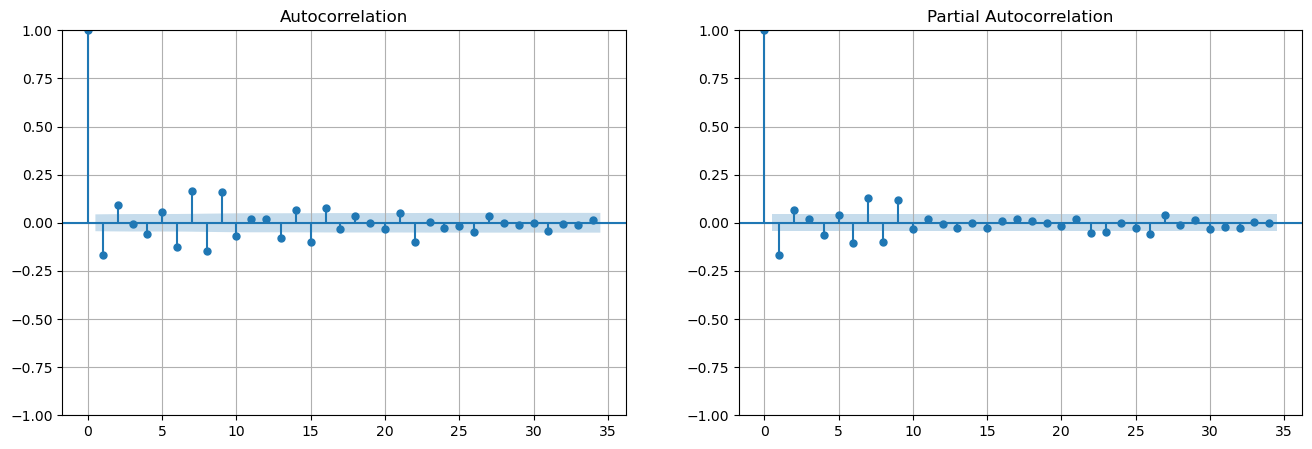

In [388]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
plot_acf(y_train, ax = ax[0]);
ax[0].grid()
plot_pacf(y_train, ax = ax[1], method = 'ywm');
ax[1].grid()

In [389]:
randomwalk = SARIMAX(y1_train, order=(0, 1, 0), trend='c').fit()

In [390]:
start_index = len(y1_train)
end_index = len(y1_train) + len(y1_test) - 1
randomwalk_preds = randomwalk.predict(start=start_index, end=end_index,dynamic=True)
random_mse_test = mean_squared_error(randomwalk_preds, y1_test)
### ANSWER CHECK
print(randomwalk_preds)
print(random_mse_test)
print(f" RMSE: {np.sqrt(random_mse_test)}")

1999   -0.001080
2000   -0.001089
2001   -0.001099
2002   -0.001109
2003   -0.001118
          ...   
2493   -0.005826
2494   -0.005836
2495   -0.005846
2496   -0.005855
2497   -0.005865
Name: predicted_mean, Length: 499, dtype: float64
0.00012178862368798614
 RMSE: 0.011035788312938326


The Random Walk gave us a baseline RMSE of .028, which is above the std dev of log returns, meaning that the model is not actually predictive.

In [391]:
arma = ARIMA(y1_train, order = (1, 0, 1)).fit()

In [413]:
start_index = len(y1_train)
end_index = len(y1_train) + len(y1_test) - 1
preds = arma.predict(start=start_index, end=end_index,dynamic=True)
mse_test = mean_squared_error(preds, y1_test)
### ANSWER CHECK
print(preds)
print(f" RMSE: {np.sqrt(mse_test)}")

1999    0.000719
2000    0.000274
2001    0.000488
2002    0.000385
2003    0.000435
          ...   
2493    0.000419
2494    0.000419
2495    0.000419
2496    0.000419
2497    0.000419
Name: predicted_mean, Length: 499, dtype: float64
 RMSE: 0.010125989165586317


In [393]:
preds.tail(300)

2198    0.000419
2199    0.000419
2200    0.000419
2201    0.000419
2202    0.000419
          ...   
2493    0.000419
2494    0.000419
2495    0.000419
2496    0.000419
2497    0.000419
Name: predicted_mean, Length: 300, dtype: float64

Below I am building a SARIMAX model, it is a similar concept to the ARIMA I built previously, but allows me to pass through exogenous data like data from other indicies and economic factors. My hope is that this model will be able to combine the sequential nature of the data and the economic data and be able to effectively predict using both. 

In [394]:
sarimax = SARIMAX(y1_train,exog=X1_train,  order=(1, 0, 1), seasonal_order=(0, 0, 0, 0)).fit()

In [395]:
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            log_returns   No. Observations:                 1999
Model:               SARIMAX(1, 0, 1)   Log Likelihood                6063.724
Date:                Tue, 12 Aug 2025   AIC                         -12111.449
Time:                        13:52:09   BIC                         -12066.645
Sample:                             0   HQIC                        -12094.997
                               - 1999                                         
Covariance Type:                  opg                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
sp_500_prev_day_close -5.392e-05   1.27e-05     -4.255      0.000   -7.88e-05   -2.91e-05
vix_prev_day             -0.0006   5.33e-05    -10.540      0.000      -0.001      -0.000
nasdaq_prev_day        1.537e-05   4.02e-06      3.820      0.000    7.49e-06    2.33e-05
russell_2000_prev_day     0.0017   5.07e-05     33.209      0.000       0.002       0.002
prev_volume           -1.077e-13   6.71e-12     -0.016      0.987   -1.33e-11     1.3e-11
ar.L1                     0.0712   5.85e-09   1.22e+07      0.000       0.071       0.071
ma.L1                    -0.0709   5.81e-09  -1.22e+07      0.000      -0.071      -0.071
sigma2                    0.0001   1.63e-06     83.386      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             13958.97
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.10   Skew:                            -0.91
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.18e+23. Standard errors may be unstable.
"""

In [396]:
sarimax_start_index = len(y1_train)
sarimax_end_index = len(y1_train) + len(y1_test) - 1
sarimax_preds = sarimax.predict(start=start_index, end=end_index, exog=X1_test,dynamic=True)
sarimax_mse_test = mean_squared_error(sarimax_preds, y1_test)
### ANSWER CHECK
print(sarimax_preds)
print(sarimax_mse_test)

1999    0.000801
2000    0.001222
2001    0.000048
2002    0.000634
2003   -0.001012
          ...   
2493   -0.001266
2494   -0.000465
2495    0.001078
2496    0.001393
2497   -0.000432
Name: predicted_mean, Length: 499, dtype: float64
0.00010914466356971054


In [397]:
print(f" RMSE: {np.sqrt(sarimax_mse_test)}")

 RMSE: 0.010447232340180367


In [398]:
np.std(y1_test)

0.010121453885171033

Below I am building an LSTM, first I will take the difference of the data and scale it to ensure that the data is Stationary and ready to be modeled.

In [399]:
lstmdata = data.drop(['close_price','points_change'],axis=1)
result = adfuller(lstmdata['log_returns'])

# The result is a tuple, so we can unpack it
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

ADF Statistic: -15.946993
p-value: 0.000000
Critical Values:
	1%: -3.4329778809556224
	5%: -2.86270098200392
	10%: -2.5673880359934063


In [400]:
train = lstmdata['2015-9-1':].diff().dropna()
test = lstmdata['2023-8-14':].diff().dropna()

In [401]:
#SCALED DATA:
train_scaled = MinMaxScaler(feature_range=(0, 1)).fit_transform(train)
test_scaled = MinMaxScaler(feature_range=(0, 1)).fit_transform(test)

In [402]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train)

,feature_range,"(0, ...)"
,copy,True
,clip,False


In [403]:
def create_sequences(data, seq_length):
    X = []
    y = []
    # Loop from the beginning of the data until the end,
    # leaving enough room for the last sequence and its target
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length, 5])
    return np.array(X), np.array(y)



In [404]:

seq_length = 30  # For example, using the last 90 trading days

# Create sequences for the training set
X3_train, y3_train = create_sequences(train_scaled, seq_length)

# Create sequences for the testing set
X3_test, y3_test = create_sequences(test_scaled, seq_length)


In [405]:
print("X_train shape:", X3_train.shape)
print("y_train shape:", y3_train.shape)
print("X_test shape:", X3_test.shape)
print("y_test shape:", y3_test.shape)
n_timesteps = X3_train.shape[1]
n_features = X3_train.shape[2]

X_train shape: (2469, 30, 6)
y_train shape: (2469,)
X_test shape: (469, 30, 6)
y_test shape: (469,)


In [406]:
lstm = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.LSTM(25, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])

lstm.compile(loss="mse", optimizer="adam")


In [410]:
lstmfinal = lstm.fit(X3_train, y3_train,epochs=20,batch_size=32,validation_split=0.01, verbose=1)


Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0020 - val_loss: 7.0696e-04
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0020 - val_loss: 5.7201e-04
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0020 - val_loss: 8.8386e-04
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0020 - val_loss: 5.6227e-04
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0020 - val_loss: 5.6274e-04
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0019 - val_loss: 5.6114e-04
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0019 - val_loss: 5.8706e-04
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0019 - val_loss: 5.7976e-04
Epoch 9/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0019 - val_loss: 6.1023e-04
Epoch 10/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0020 - val_loss: 5.6968e-04
Epoch 11/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0020 - val_loss: 6.0438e-04
Epoch 12/20
77/77 ━

In [411]:
y_pred_lstm = lstm.predict(X3_test)
# Create an empty array to hold the inverse transformed values
y_test_unscaled = np.zeros(shape=(len(y3_test), lstmdata.shape[1]))
y_pred_unscaled = np.zeros(shape=(len(y_pred_lstm), lstmdata.shape[1]))
# Replace the first column with the target values
y_test_unscaled[:, 0] = y3_test
y_pred_unscaled[:, 0] = y_pred_lstm[:, -1, 0]

# Inverse transform the data
y_test_unscaled = scaler.inverse_transform(y_test_unscaled)[:, 0]
y_pred_unscaled = scaler.inverse_transform(y_pred_unscaled)[:, 0]


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [412]:
mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)
rmse = np.sqrt(mse)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")

Mean Squared Error: 2867.9834
Root Mean Squared Error: 53.5536
